# Intro to RNNs
This notebook is part of the [SachsLab Workshop for Intracranial Neurophysiology and Deep Learning](https://github.com/SachsLab/IntracranialNeurophysDL).

Run the first two cells to normalize Local / Colab environments, then proceed below for the lesson.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
try:
    # See if we are running on google.colab
    import google.colab
    IN_COLAB = True
    # Setup tensorflow 2.0
    !pip install -q tensorflow-gpu==2.0.0-alpha0
except ModuleNotFoundError:
    IN_COLAB = False
    import sys
    if Path.cwd().stem == 'notebooks':
        os.chdir(Path.cwd().parent)
# Common imports
import numpy as np
import tensorflow as tf

A recurrent neural network (RNN) is an artificial neural network that maintains an internal state (memory)
as it processes items in a sequence. RNNs are most often applied to sequence data such as text
(sequences of characters; sequences of words) or time series (e.g., stock prices, weather data, neurophysiology).
RNNs can provide an output at each step of the sequence to predict different sequences (e.g., text translation) or
the next item in the same sequence (e.g., assistive typing, stock prediction, prosthetic control).
The loss does not back-propagate to update weights until the sequence is complete. RNNs can also be configured
to produce a single output at the end of a sequence (e.g., classify a tweet sentiment, decode categorical intention).

## RNN Step-by-Step
We will create our own RNN step-by-step. We will train it using toy data that we generate.
### Generate data
X is a multi-channel time series and Y is a different multi-channel time series
constructed from a linear combination of a delayed version of X.

In [4]:
PEAK_FREQS = [10, 22, 75]
FS = 1000.0
DURATION = 5.0
DELAY = 0.003
N_OUT = 2

n_samples = int(DURATION * FS)
delay_samples = int(DELAY * FS)
t_vec = np.arange(n_samples + delay_samples) / FS

X = np.zeros((n_samples + delay_samples, len(PEAK_FREQS)), dtype=np.float32)
for chan_ix, pf in enumerate(PEAK_FREQS):
    X[:, chan_ix] = (1 / (chan_ix + 1) ) * np.sin(t_vec * 2 * np.pi * pf)

# Create mixing matrix that mixes inputs into outputs
W = np.random.rand(N_OUT, len(PEAK_FREQS))
W = W / np.sum(W, axis=1, keepdims=True)

Y = W @ X[:-delay_samples, :].T
Y = Y.T
X = X[delay_samples:, :]
t_vec = t_vec[delay_samples:]

X += 0.1*np.random.rand(*X.shape)
Y += 0.1*np.random.rand(*Y.shape)

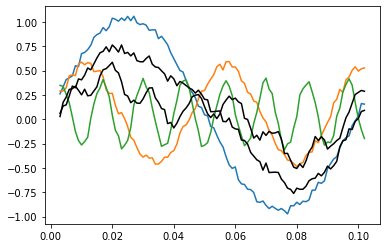

In [6]:
import matplotlib.pyplot as plt
plt.plot(t_vec[:100], X[:100, :])
plt.plot(t_vec[:100], Y[:100, :], 'k')
plt.show()

### Define forward pass

In [7]:
state_t = np.zeros((N_OUT,))
W = np.random.random((N_OUT, X.shape[1]))  # Mixes input with output
U = np.random.random((N_OUT, N_OUT))       # Mixes old state with output
b = np.random.random((N_OUT,))             # Bias term
successive_outputs = []
for x_t in X:
    y_t = np.tanh(np.dot(W, x_t) + np.dot(U, state_t) + b)
    successive_outputs.append(y_t)
    state_t = y_t
final_output_sequence = np.concatenate(successive_outputs, axis=0)

### Define loss and update
TODO 

## RNN in Tensorflow
[Tutorial](https://www.tensorflow.org/tutorials/sequences/text_generation) (text generation w/ eager)

### Prepare data for Tensorflow
In the tutorial linked above, the `batch` transformation is used to convert a continuous sequence into
many sequences, then the batch transform is used AGAIN to get batches of sequences.

In [46]:
SEQ_LENGTH = 300
BATCH_SIZE = 2
BUFFER_SIZE = 10000

_X = []
_Y = []
for seq_ix in range(X.shape[0] // SEQ_LENGTH):
    _X.append(X[seq_ix*SEQ_LENGTH:(seq_ix+1)*SEQ_LENGTH, :])
    _Y.append(Y[seq_ix*SEQ_LENGTH:(seq_ix+1)*SEQ_LENGTH, :])
_X = np.stack(_X)
_Y = np.stack(_Y)

dataset = tf.data.Dataset.from_tensor_slices((_X, _Y))
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [47]:
for _x, _y in dataset.take(1):
    print(_x)

tf.Tensor(
[[[ 0.2614715   0.29112336  0.34837657]
  [ 0.33201295  0.29032934  0.33824018]
  [ 0.4083197   0.3237239   0.25607744]
  ...
  [ 0.02168297 -0.29189467  0.07763105]
  [ 0.06776177 -0.2574337  -0.06060752]
  [ 0.21202512 -0.3238146  -0.26227129]]

 [[ 0.21851367 -0.43064097 -0.25910988]
  [ 0.2735122  -0.4457417  -0.2761878 ]
  [ 0.3194438  -0.43614036 -0.20176663]
  ...
  [ 0.03723451  0.5319108   0.05758632]
  [ 0.11173303  0.5463566   0.15313752]
  [ 0.16793774  0.5584957   0.341694  ]]], shape=(2, 300, 3), dtype=float32)


### Define RNN model in Tensorflow

In [34]:
inputs = tf.keras.layers.Input(shape=(SEQ_LENGTH, _X.shape[-1]))
outputs = tf.keras.layers.SimpleRNN(N_OUT, return_sequences=True)(inputs)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='Nadam', loss='mean_squared_error')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 300, 3)]          0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 300, 2)            12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________


In [35]:
EPOCHS = 20
history = model.fit(x=dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20


ValueError: Empty training data.